In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.keras.backend.clear_session()

### dataset information

In [5]:
from datetime import datetime

dataset = "mnist"
dims = (28, 28, 1)
umap_prop = 1e-10#1.0
classif_prop = 0.0
relative_distance_prop = 1.0
num_classes = 10
PROJECTION_DIMS = 2
labels_per_class = 'full'
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(umap_prop)
    + "_"
    + str(PROJECTION_DIMS)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring
    + "_global"
)
print(datestring)

mnist_1e-10_2_full____2020_08_04_12_07_23_126357_global


### Load packages

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [7]:
from tfumap.load_datasets import load_MNIST, mask_labels

In [8]:
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_MNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [9]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build umap graph

In [10]:
from tfumap.semisupervised import build_fuzzy_simplicial_set

In [11]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    #y=Y_masked,
    n_neighbors=n_neighbors,
)

### Build data iterators

In [12]:
from tfumap.umap import compute_cross_entropy, get_graph_elements
from tfumap.semisupervised import create_edge_iterator, create_validation_iterator, create_classification_iterator

In [13]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 1000])
batch_size

1000

In [14]:
# make sure batch size is no bigger than the number of labels per class
labeled_batch_size = batch_size if batch_size < len(Y_labeled) else len(Y_labeled)
labeled_batch_size = 128
labeled_iter = create_classification_iterator(X_labeled, Y_labeled, batch_size=batch_size)
print(labeled_batch_size)

128


In [15]:
max_sample_repeats_per_epoch = 25
edge_iter, n_edges_per_epoch = create_edge_iterator(
    head,
    tail,
    weight,
    batch_size=batch_size,
    max_sample_repeats_per_epoch=max_sample_repeats_per_epoch,
)

In [16]:
data_valid, n_valid_samp = create_validation_iterator(X_valid, Y_valid, batch_size, repeat=True)

### Build network

In [17]:
encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.InputLayer(input_shape=dims))
encoder.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=3, strides=1, padding="same", activation="relu"
))
encoder.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=3, strides=1, padding="same", activation="relu"
))
encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
encoder.add(tf.keras.layers.Dropout(0.25))
encoder.add(tf.keras.layers.Flatten())
encoder.add(tf.keras.layers.Dense(units=128, activation="relu"))
encoder.add(tf.keras.layers.Dropout(0.25))

In [18]:
classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=128))
classifier.add(tf.keras.layers.Dense(units=128, activation="relu"))
classifier.add(tf.keras.layers.Dense(units=128, activation="relu"))
classifier.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="predictions"))

In [19]:
embedder = tf.keras.Sequential()
embedder.add(tf.keras.Input(shape=(128)))
embedder.add(tf.keras.layers.Dense(units=128, activation="relu"))
embedder.add(tf.keras.layers.Dense(units=128, activation="relu"))
embedder.add(tf.keras.layers.Dense(PROJECTION_DIMS, activation=None, name='z'))

In [20]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1605760   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

### Create UMAP object

In [21]:
from tfumap.semisupervised_model import PUMAP, compute_classifier_loss

In [22]:
import tensorflow as tf
from tfumap.umap import compute_cross_entropy, convert_distance_to_probability
from tfumap.semisupervised import (
    find_a_b,
    #compute_umap_loss,
    # compute_classifier_loss,
    batch_data,
)
import numpy as np
import os, tempfile
from tqdm.autonotebook import tqdm
from datetime import datetime


In [24]:
def compute_relative_distance_loss(batch_to, batch_from, embedding_to, embedding_from):
    """ encouranges the relative distance in X to be the same as in Z
    """
    # shuffle
    idx1 = tf.random.shuffle(tf.range(tf.shape(batch_from)[0]))
    idx2 = tf.random.shuffle(tf.range(tf.shape(batch_from)[0]))

    # get euclidean distance in x
    dx1 = tf.norm(
        tf.keras.layers.Flatten()(batch_to)
        - tf.keras.layers.Flatten()(tf.gather(batch_from, idx1)),
        axis=1,
    )
    dx2 = tf.norm(
        tf.keras.layers.Flatten()(batch_to)
        - tf.keras.layers.Flatten()(tf.gather(batch_from, idx2)),
        axis=1,
    )
    # get wheter x1 or x2 is closer to x
    x_sign = tf.sign(dx1 - dx2)
    # get euclidean distance in z
    dz1 = tf.norm(embedding_to - tf.gather(embedding_from, idx1), axis=1)
    dz2 = tf.norm(embedding_to - tf.gather(embedding_from, idx2), axis=1)
    # get whether z1 or z2 is closer to z
    z_sign = tf.sign(dz1 - dz2)
    
    # get relative distance loss (scaling x_sign and z_sign between 0 and 1)
    relative_distance_loss = tf.keras.losses.binary_crossentropy((x_sign + 1) / 2, (z_sign + 1) / 2)
    return relative_distance_loss

In [25]:
def compute_umap_loss(
    batch_to,
    batch_from,
    embedder,
    encoder,
    _a,
    _b,
    negative_sample_rate=5,
    repulsion_strength=1,
):
    """
        compute the cross entropy loss for learning embeddings

        Parameters
        ----------
        batch_to : tf.int or tf.float32
            Either X or the index locations of the embeddings for verticies (to)
        batch_from : tf.int or tf.float32
            Either X or the index locations of the embeddings for verticies (from)

        Returns
        -------
        ce_loss : tf.float
            cross entropy loss for UMAP
        embedding_to : tf.float
            embeddings for verticies (to)
        embedding_from : tf.float
            embeddings for verticies (from)
        """

    # encode
    embedding_to = embedder(encoder(batch_to))
    embedding_from = embedder(encoder(batch_from))

    # get negative samples
    embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
    repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
    embedding_neg_from = tf.gather(
        repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
    )

    #  distances between samples
    distance_embedding = tf.concat(
        [
            tf.norm(embedding_to - embedding_from, axis=1),
            tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
        ],
        axis=0,
    )

    # convert probabilities to distances
    probabilities_distance = convert_distance_to_probability(distance_embedding, _a, _b)

    # treat positive samples as p=1, and negative samples as p=0
    probabilities_graph = tf.concat(
        [tf.ones(embedding_to.shape[0]), tf.zeros(embedding_neg_to.shape[0])], axis=0,
    )

    # cross entropy loss
    (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
        probabilities_graph,
        probabilities_distance,
        repulsion_strength=repulsion_strength,
    )

    relative_distance_loss = compute_relative_distance_loss(
        batch_to, batch_from, embedding_to, embedding_from
    )
    return (
        attraction_loss,
        repellant_loss,
        ce_loss,
        relative_distance_loss
    )

In [26]:


@tf.function
def compute_classifier_loss(X, y, encoder, classifier, sparse_ce, acc_func):
    """ compute the cross entropy loss for classification
        """
    d = classifier(encoder(X))
    loss = sparse_ce(y, d)
    acc = acc_func(y, d)
    #acc = tf.keras.metrics.sparse_categorical_accuracy(y, d)
    return loss, acc


class PUMAP(tf.keras.Model):
    def __init__(
        self,
        encoder,
        embedder,
        classifier,
        tensorboard_logdir=None,  # directory for tensorboard log
        min_dist=0.1,
        negative_sample_rate=5.0,
        optimizer=tf.keras.optimizers.SGD(0.1),
        repulsion_strength=1.0,
        umap_prop=1.0,  # to what extent do we train UMAP
        classif_prop = 1.0,
        relative_distance_prop = 1.0,
        # ** kwargs,
    ):
        super(PUMAP, self).__init__()
        # self.__dict__.update(kwargs)

        # subnetworks
        self.embedder = embedder
        self.encoder = encoder
        self.classifier = classifier

        self.umap_prop = umap_prop
        self.classif_prop = classif_prop
        self.relative_distance_prop = relative_distance_prop
        
        # optimizer for cross entropy minimization
        self.optimizer = optimizer
        self.repulsion_strength = repulsion_strength
        self.negative_sample_rate = negative_sample_rate

        # get a,b for current min_dist
        self._a, self._b = find_a_b(min_dist)

        # create summary writer to log loss information during training
        if tensorboard_logdir is None:
            self.tensorboard_logdir = os.path.join(
                tempfile.gettempdir(),
                "tensorboard",
                datetime.now().strftime("%Y%m%d-%H%M%S"),
            )
        else:
            self.tensorboard_logdir = tensorboard_logdir
        self.summary_writer_train = tf.summary.create_file_writer(
            self.tensorboard_logdir + "/train"
        )
        self.summary_writer_valid = tf.summary.create_file_writer(
            self.tensorboard_logdir + "/valid"
        )

        # sparse categorical cross entropy
        self.sparse_ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.class_acc = tf.keras.metrics.SparseCategoricalAccuracy()
        self.class_acc_val = tf.keras.metrics.SparseCategoricalAccuracy()

        # self.create_summary_metrics()

    @tf.function
    def train(self, batch_to, batch_from, X, y, save_loss=False):
        """ One training step 
        Input are points and weights for positive and negative 
        samples for training. 
            
        """
        if self.umap_prop > 0:
            with tf.GradientTape() as tape:

                (attraction_loss, repellant_loss, umap_loss, relative_distance_loss) = compute_umap_loss(
                    batch_to,
                    batch_from,
                    self.embedder,
                    self.encoder,
                    self._a,
                    self._b,
                    self.negative_sample_rate,
                    self.repulsion_strength,
                )
            
                classifier_loss, classifier_acc = compute_classifier_loss(
                    X, y, self.encoder, self.classifier, self.sparse_ce, self.class_acc
                )
                loss = (
                    tf.reduce_mean(classifier_loss) * self.classif_prop
                    + tf.reduce_mean(umap_loss) * self.umap_prop
                    + relative_distance_loss * self.relative_distance_prop
                )

            train_vars = (
                self.encoder.trainable_variables
                + self.embedder.trainable_variables
                + self.classifier.trainable_variables
            )
        else:  # ignore running costly UMAP computations if not training on UMAP loss
            with tf.GradientTape() as tape:
                classifier_loss, classifier_acc = compute_classifier_loss(
                    X, y, self.encoder, self.classifier, self.sparse_ce, self.class_acc
                )
                loss = classifier_loss
            train_vars = (
                self.encoder.trainable_variables + self.classifier.trainable_variables
            )
            attraction_loss = repellant_loss = umap_loss = relative_distance_loss = 0

        # compute gradient for umap
        grad = tape.gradient(loss, train_vars)

        # gradients are cliped in UMAP implementation. Any effect here?
        grad = [tf.clip_by_value(grad, -4.0, 4.0) for grad in grad]

        self.optimizer.apply_gradients(zip(grad, train_vars))

        return (
            attraction_loss,
            repellant_loss,
            tf.reduce_mean(umap_loss),
            classifier_loss,
            classifier_acc,
            relative_distance_loss,
        )

    @tf.function
    def write_losses(
        self,
        step,
        classifier_acc,
        classifier_loss,
        umap_loss,
        classifier_loss_val,
        classifier_acc_val,
        relative_distance_loss
    ):
        # write train loss
        with self.summary_writer_train.as_default():
            tf.summary.scalar(
                "classif_acc", classifier_acc, step=step,
            )
            tf.summary.scalar(
                "classif_loss", classifier_loss, step=step,
            )
            tf.summary.scalar(
                "umap_loss", umap_loss, step=step,
            )
            tf.summary.scalar(
                "relative_distance_loss", relative_distance_loss, step=step,
            )
            self.summary_writer_train.flush()
        # write valid loss
        with self.summary_writer_valid.as_default():
            tf.summary.scalar(
                "classif_acc", classifier_acc_val, step=step,
            )
            tf.summary.scalar(
                "classif_loss", classifier_loss_val, step=step,
            )
            self.summary_writer_valid.flush()



In [27]:
### Initialize model
model = PUMAP(
    min_dist = 0.0,
    negative_sample_rate = 5, # how many negative samples per positive
    optimizer=tf.keras.optimizers.Adam(1e-4), # cross-entropy optimizer
    encoder=encoder,
    embedder=embedder,
    classifier=classifier,
    umap_prop=umap_prop,
    classif_prop = classif_prop,
    relative_distance_prop = relative_distance_prop
    
)

### plotting results

In [28]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

from tfumap.semisupervised_plotting import embed_data
def plot_umap_global_results(
    model,
    X_valid,
    Y_valid,
    X_train,
    X_labeled,
    Y_labeled,
    batch_size,
    cmap="coolwarm",
    cmap2="bwr",
):
    # get loss dataframe from tensorboard
    try:
        loss_df = retrieve_tensors(model.tensorboard_logdir)
        losses_exist = True
    except ValueError as e:
        print(e)
        losses_exist = False

    # embed data
    embedding_valid = embed_data(X_valid, model, batch_size)
    embedding_train = embed_data(X_train, model, batch_size)


    # plot
    fig, axs = plt.subplots(ncols=3, figsize=(20, 4))
    ax = axs[0]

    ax.scatter(
        embedding_valid[:, 0],
        embedding_valid[:, 1],
        c=Y_valid,
        cmap=cmap,  # "tab10"
        s=2,
        alpha=0.25,
        rasterized=True,
    )
    ax.set_title("Projection data", fontsize=24)
    ax.axis("equal")

    if losses_exist:
        ax = axs[1]
        sns.lineplot(
            x="step",
            y="val",
            hue="group",
            data=loss_df[loss_df.variable == "umap_loss"],
            ci=None,
            ax=ax,
        )
        ax.legend(loc="upper right")
        ax.set_xscale("log")
        ax.set_title("UMAP loss", fontsize=24)
        ax.set_ylabel("Cross Entropy")
        
        ax = axs[2]
        sns.lineplot(
            x="step",
            y="val",
            hue="group",
            data=loss_df[loss_df.variable == "relative_distance_loss"],
            ci=None,
            ax=ax,
        )
        ax.legend(loc="upper right")
        ax.set_xscale("log")
        ax.set_title("Relative Distance loss", fontsize=24)
        ax.set_ylabel("Cross Entropy")
    plt.show()


In [29]:
from tfumap.semisupervised_plotting import plot_umap_classif_results, plot_results, get_decision_contour

No objects to concatenate


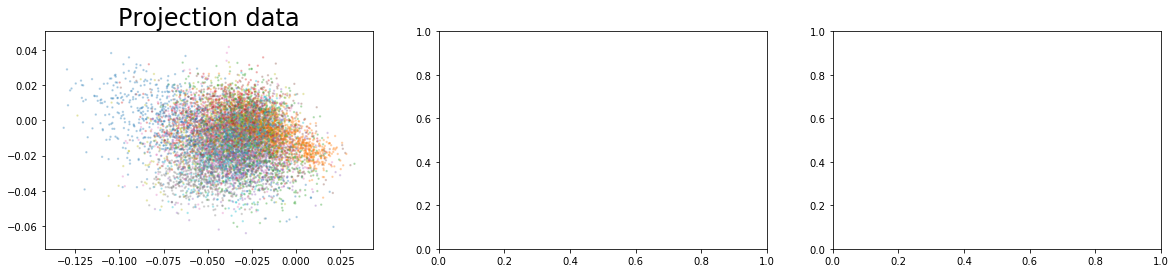

In [30]:
plot_umap_global_results(model, X_valid, Y_valid, X_train, X_labeled, Y_labeled, batch_size, cmap='tab10', cmap2='tab10')

### Train model

In [31]:
from tfumap.paths import MODEL_DIR

In [32]:
batch = 0; epoch = 0
N_EPOCHS = 50
BATCHES_PER_EPOCH = int(n_edges_per_epoch / batch_size)

In [33]:
# early stopping parameters
patience = 10000 # wait this many batches without improvement before early stopping
min_delta = 0.0001 # threshold for what counts as an improvement
best_acc = 0 # the best current accuracy score
last_improvement = 0 # delta between current batch, and the last batch that was an improvement
best_saved_acc = 0 # best accuracy on valid data that has been checkpointed
best_saved_batch = 0 # batch number for last good batch
max_reinitialize_delta = .01 # minimum loss in accuracy resulting in reinitialized weights
plot_frequency = 1000 # how frequently to plot
save_frequency = 2500 # how frequently to save batches
early_stopping = False
# where to save checkpoints
cpt_path = MODEL_DIR / 'global' / dataset / datestring
# how often can we reload weights?
max_reloads = 10
n_reloads = 0

In [34]:
tolerance = 100
batches_since_last_reload = 0

In [35]:
max_save_delta = 0.05

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


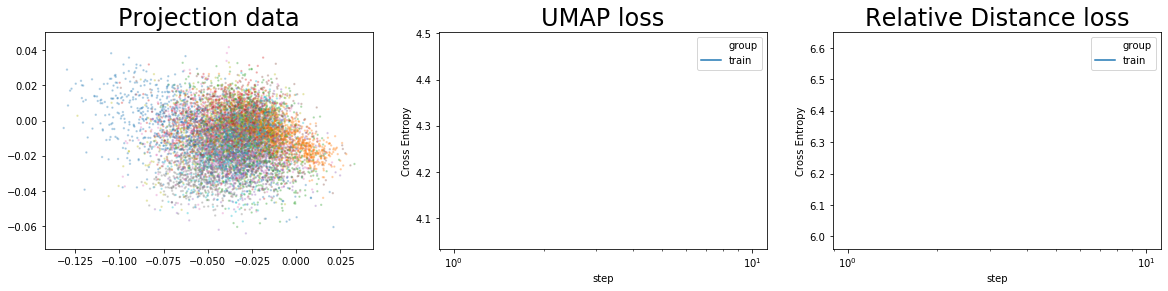

batch: 0 | train acc: 0.1 | val acc: 0.115


KeyboardInterrupt: 

In [36]:
for edge_epoch, epoch in tqdm(zip(edge_iter, np.arange(N_EPOCHS)), total=N_EPOCHS, desc = 'epoch'):
    for (batch_to, batch_from), (X, y), (X_val, y_val) in tqdm(
        zip(edge_epoch, labeled_iter, data_valid), total=BATCHES_PER_EPOCH, leave=False, desc = 'batch'
    ):

        # train
        (
            attraction_loss,
            repellant_loss,
            umap_loss,
            classifier_loss,
            classifier_acc,
            relative_distance_loss
        ) = model.train(
            batch_to=X_train[batch_to], batch_from=X_train[batch_from], X=X, y=y
        )

        # compute validation loss
        val_loss, val_acc = compute_classifier_loss(
            X_val,
            y_val,
            model.encoder,
            model.classifier,
            model.sparse_ce,
            model.class_acc_val,
        )

        # save losses
        model.write_losses(
            tf.convert_to_tensor(batch, dtype=tf.int64),
            classifier_acc,
            classifier_loss,
            umap_loss,
            val_loss,
            val_acc,
            relative_distance_loss
        )

        # plot results
        if batch % plot_frequency == 0:
            plot_umap_global_results(
                model,
                X_valid,
                Y_valid,
                X_train,
                X_labeled,
                Y_labeled,
                batch_size,
                cmap="tab10",
                cmap2="tab10",
            )
            print(
                "batch: {} | train acc: {} | val acc: {}".format(
                    str(batch),
                    str(round(classifier_acc.numpy(), 4)),
                    str(round(val_acc.numpy(), 4)),
                )
            )
        batch +=1

In [ ]:
# correlation bwete

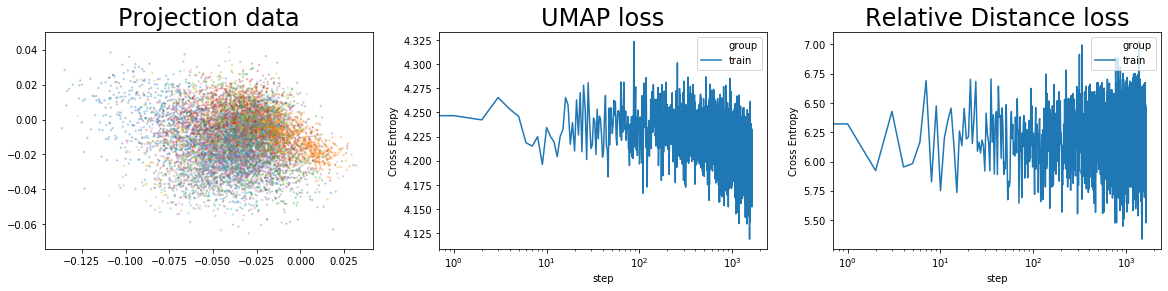

In [37]:
plot_umap_global_results(
                model,
                X_valid,
                Y_valid,
                X_train,
                X_labeled,
                Y_labeled,
                batch_size,
                cmap="tab10",
                cmap2="tab10",
            )

In [38]:
embedding_valid = embed_data(X_valid, model, batch_size)

In [39]:
from scipy.spatial import distance_matrix

In [40]:
nex = 100
dist_mat_z = distance_matrix(embedding_valid[:nex], embedding_valid[:nex])
dist_mat_x = distance_matrix(X_valid[:nex].reshape((nex, np.product(dims))), X_valid[:nex].reshape((nex, np.product(dims))))

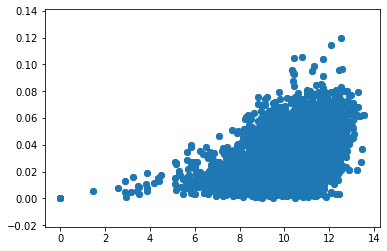

In [41]:
plt.scatter(dist_mat_x.flatten(), dist_mat_z.flatten())

In [ ]:
np.flatten(dist_mat)

In [ ]:
scipy.spatial.distance_matrix

In [ ]:
breakme

In [ ]:
batch

In [ ]:
batch_to=X_train[batch_to]
batch_from=X_train[batch_from]

In [ ]:
# encode
embedding_to = embedder(encoder(batch_from))
embedding_from = embedder(encoder(batch_from))

In [ ]:
for i in tqdm(range(1000)):
    test = compute_relative_distance_loss(batch_to, batch_from, embedding_to, embedding_from)

In [ ]:
test

In [ ]:
# get x, z
x = batch_to
z = embedding_to
# shuffle
idx1 = tf.random.shuffle(tf.range(tf.shape(batch_from)[0]))
idx2 = tf.random.shuffle(tf.range(tf.shape(batch_from)[0]))
x1 = tf.gather(batch_from, idx1)
x2 = tf.gather(batch_from, idx2)
z1 = tf.gather(embedding_from, idx1)
z2 = tf.gather(embedding_from, idx2)
# get euclidean distance in x
dx1 = tf.norm(tf.keras.layers.Flatten()(x) - tf.keras.layers.Flatten()(x1), axis=1)
dx2 = tf.norm(tf.keras.layers.Flatten()(x) - tf.keras.layers.Flatten()(x2), axis=1)
# get wheter x1 or x2 is closer to x
x_sign = tf.sign(dx1 - dx2)
# get euclidean distance in z
dz1 = tf.norm(tf.keras.layers.Flatten()(z) - tf.keras.layers.Flatten()(z1), axis=1)
dz2 = tf.norm(tf.keras.layers.Flatten()(z) - tf.keras.layers.Flatten()(z2), axis=1)
# get whether z1 or z2 is closer to z
z_sign = tf.sign(dz1 - dz2)
# scale between 0 and 1
x_sign = (x_sign + 1) / 2
z_sign = (z_sign + 1) / 2
# get relative distance loss
relative_distance_loss = tf.keras.losses.binary_crossentropy(x_sign, z_sign)

In [ ]:
b

### Save results

In [ ]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

from tfumap.semisupervised_plotting import embed_data

loss_df = retrieve_tensors(model.tensorboard_logdir)
loss_df['step'] +=1
loss_df

In [ ]:
loss_df.to_pickle(cpt_path / 'loss_df.pickle')

In [ ]:
valid_acc = loss_df[
    (loss_df.group.values == "valid") & (loss_df.variable.values == "classif_acc")
].val.values

In [ ]:
plt.plot(valid_acc)

In [ ]:
y_pred = [model.classifier(model.encoder(np.expand_dims(i, 0))) for i in tqdm(X_test)]
y_pred = np.vstack(y_pred)

In [ ]:
test_acc = tf.keras.metrics.sparse_categorical_accuracy(
    Y_test, y_pred
).numpy()
print(np.mean(test_acc))

In [ ]:
np.save(cpt_path / 'test_acc.npy', test_acc)